In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import gpiozero
import time
#import rpio.gpio
import RPi
from gpiozero.pins.rpigpio import RPiGPIOFactory
from gpiozero import Device
#from gpiozero import RotaryEncoder
factory = RPiGPIOFactory()

In [2]:
pwm1 = gpiozero.PWMOutputDevice(pin=12,active_high=True,initial_value=0,frequency=50000)
dir1 = gpiozero.OutputDevice(pin=4)
pwm2 = gpiozero.PWMOutputDevice(pin=13,active_high=True,initial_value=0,frequency=50000)
dir2 = gpiozero.OutputDevice(pin=26)

In [3]:
encoder1 = gpiozero.RotaryEncoder(a=6, b=5,max_steps=100000) 
encoder2 = gpiozero.RotaryEncoder(a=23, b=24,max_steps=100000) 

In [4]:
class DiffDriveRobot:
    
    def __init__(self,inertia=5, dt=0.1, drag=0.2, wheel_radius=0.0275, wheel_sep=0.094):
        
        self.x = 0.0 # y-position
        self.y = 0.0 # y-position 
        self.th = 0.0 # orientation
        self.pre_steps1 = 0
        self.pre_steps2 = 0
        self.wl = 0#rotational velocity left wheel
        self.wr =0 #rotational velocity right wheel
        
        self.I = inertia
        self.d = drag
        self.dt = dt
        
        self.r = wheel_radius
        self.l = wheel_sep
        
    # Should be replaced by motor encoder measurement which measures how fast wheel is turning
    # Here, we simulate the real system and measurement
    def motor_simulator(self,w,duty_cycle,encoder,previousTime,steps_old):
        radiansPerStep = 2 * np.pi /32
        #w = ((encoder /32 ) / 38.2) * 0.0275 * 2 * np.pi
        #print("encodersteps: ", encoder)
        w = ((radiansPerStep * (encoder) - (radiansPerStep * steps_old))/(time.time()-previousTime))/38.2
        #print("Time Taken: ", time.time()-previousTime)
        #print("Time Taken: ", time.time() - currentTime)
        #print("Motor_simulator w: ",w)
#         torque = self.I*duty_cycle
        
#         if (w > 0):
#             w = min(w + self.dt*(torque - self.d*w),3)
            
#         elif (w < 0):
#             w = max(w + self.dt*(torque - self.d*w),-3)
            
#         else:
#             w = w + self.dt*(torque)
        
            
        
        return w
    
    # Veclocity motion model
    def base_velocity(self,wl,wr, previousTime):
        
        v = ((wl + wr)/2)/ (time.time() - previousTime)
        
        #v = (wl*self.r + wr*self.r)/2.0 *10
        print("base_velocity v: ",v)
        w = (wl - wr)/self.l 
        
        return v, w
    
    # Kinematic motion model
    def pose_update(self,duty_cycle_l,duty_cycle_r,previousTime):
        
        
        #print("Encoder1 Steps: ", encoder1.steps)
        self.wl = self.motor_simulator(self.wl,duty_cycle_l,encoder1.steps,previousTime,self.pre_steps1)
        
        #self.wl = (((encoder1.steps - self.pre_steps1)/2)/32)/38.2#rotational velocity left wheel
       # pwm1.value = self.wl
        #self.pre_steps1 = encoder1.steps
        
        self.wr = self.motor_simulator(self.wr,duty_cycle_r,encoder2.steps,previousTime,self.pre_steps2)
        #pwm2.value = self.wr
        #self.wr = (((encoder2.steps - self.pre_steps2)/2)/32)/38.2#rotational velocity left wheel
        #print("Speed: ", self.wr)
        #self.pre_steps2 = encoder2.steps
        
        
#         if (self.wl <0):
#             dir1 = 0
#             pwm1.value = -self.wl
#         else:
#             dir1 = 1
#             pwm1.value = self.wl
#         if (self.wr <0):
#             dir2 = 0
#             pwm2.value = -self.wr
#         else:
#             dir2 = 1
#             pwm2.value = self.wr
        self.pre_steps1 = encoder1.steps
        self.pre_steps2 = encoder2.steps

        
        v, w = self.base_velocity(self.wl,self.wr, previousTime)
        print("v: ", v, " w: ", w)
        
        self.x = self.x + self.dt*v*np.cos(self.th)
        self.y = self.y + self.dt*v*np.sin(self.th)
        self.th = self.th + w*self.dt
        print("x: ", self.x, " y: ", self.y, " th: ", self.th)
        return self.x, self.y, self.th
        

In [5]:
class RobotController:
    
    def __init__(self,Kp=0.1,Ki=0.01,wheel_radius=0.0275, wheel_sep=0.094):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self,w_desired,w_measured,e_sum):
        
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum
        
        
    def drive(self,v_desired,w_desired,wl,wr):
        
        wl_desired = v_desired/self.r + self.l*w_desired/2 
        wr_desired = v_desired/self.r - self.l*w_desired/2
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired,wr,self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r
        

In [6]:
class TentaclePlanner:
    
    def __init__(self,obstacles,dt=0.1,steps=5,alpha=1,beta=0.1):
        
        self.dt = dt
        self.steps = steps
        # Tentacles are possible trajectories to follow
        self.tentacles = [(0.0,1.0),(0.0,-1.0),(0.1,1.0),(0.1,-1.0),(0.1,0.5),(0.1,-0.5),(0.1,0.0),(0.0,0.0)] # [v, w] - Velocity and rotation.
        #self.tentacles = [(0.0,10.0),(0.0,-10.0),(0.1,0.0),(0.0,0.0)]
        self.alpha = alpha
        self.beta = beta
        
        self.obstacles = obstacles
    
    # Play a trajectory and evaluate where you'd end up
    def roll_out(self,v,w,goal_x,goal_y,goal_th,x,y,th):
        
        for j in range(self.steps):
            
            x = x + self.dt*v*np.cos(th)
            y = y + self.dt*v*np.sin(th)
            th = (th + w*self.dt)
            
            if (self.check_collision(x,y)):
                return np.inf
        
        # Wrap angle error -pi,pi
        e_th = goal_th-th
        e_th = np.arctan2(np.sin(e_th),np.cos(e_th))
        
        cost = self.alpha*((goal_x-x)**2 + (goal_y-y)**2) #+ self.beta*(e_th**2)
        
        return cost
    
    def check_collision(self,x,y):
        
        min_dist = np.min(np.sqrt((x-self.obstacles[:,0])**2+(y-self.obstacles[:,1])**2))
        
        if (min_dist < 0.1):
            return True
        return False
        
    
    # Choose trajectory that will get you closest to the goal
    def plan(self,goal_x,goal_y,goal_th,x,y,th):
        
        costs =[]
        for v,w in self.tentacles:
            costs.append(self.roll_out(v,w,goal_x,goal_y,goal_th,x,y,th))
        
        best_idx = np.argmin(costs)
        
        return self.tentacles[best_idx]
        

In [7]:
#obstacles = 2*np.random.rand(20,2)-1
#print(obstacles)
obstacles = np.matrix('0.2, 0.2')

#obstacles = [[-10 -10][-20 -20]]
robot = DiffDriveRobot(inertia=10, dt=0.1, drag=2, wheel_radius=0.05, wheel_sep=0.094)
controller = RobotController(Kp=1.0,Ki=0.15,wheel_radius=0.05,wheel_sep=0.094)
planner = TentaclePlanner(obstacles,dt=0.1,steps=5,alpha=1,beta=1e-9)

KeyboardInterrupt: 

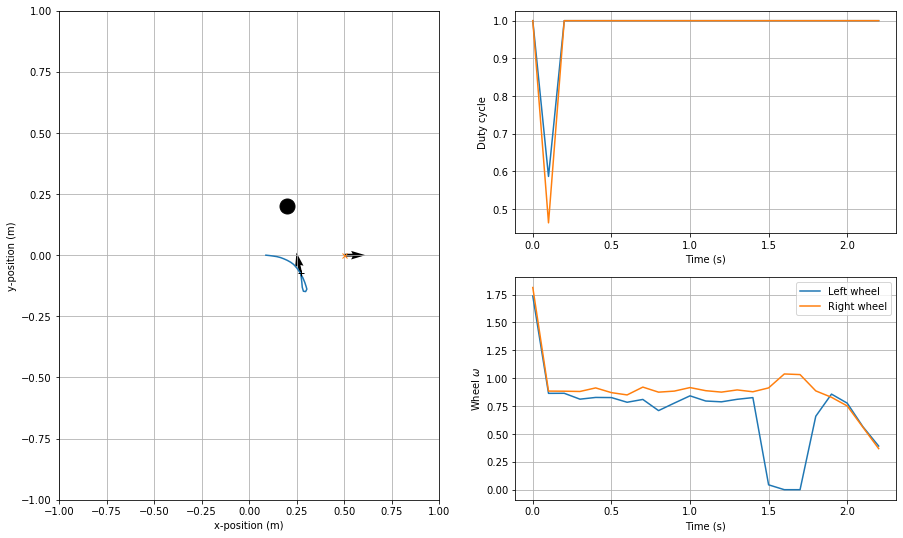

In [8]:
time.sleep(5)

plt.figure(figsize=(15,9))

poses = []
velocities = []
duty_cycle_commands = []

#goal_x = 2*np.random.rand()-1
#goal_y = 2*np.random.rand()-1
#goal_th = 2*np.pi*np.random.rand()-np.pi
previousTime = time.time()
goal_x = 0.5
goal_y = 0
goal_th = 0
for i in range(200):
    print("Distance to goal x: ", goal_x-robot.x)
    print("Distance to goal y: ", goal_y-robot.y)
    print("Robot.x: ", robot.x)
    print("Robot.y: ", robot.y)
    if abs(goal_x-robot.x) < 0.025 and abs(goal_y-robot.y) < 0.025:
        pwm1.value = 0
        pwm2.value = 0
        break

    # Example motion using controller 
    v,w = planner.plan(goal_x,goal_y,goal_th,robot.x,robot.y,robot.th)
    print("v: ", v)
    print("w: ", w)
    duty_cycle_l,duty_cycle_r = controller.drive(v,w,robot.wl,robot.wr)
#########################################################################
#This code uses the output of the functions above to actually give output
#to the pwm pins to control motors.
    if (w == 0):
        dir1 = 1
        dir2 = 1
        pwm1.value =0.55
        pwm2.value = 0.5
    elif (w>0):
        if (v >0):
            dir1 = 1
            dir2 = 1
            pwm1.value = 0.1
            pwm2.value = 1
        else:
            dir1 = 0
            dir2 = 1
            pwm1.value = 0
            pwm2.value = 0.5
    elif (w<0):
        if (v >0):
            dir1 = 1
            dir2 = 1
            pwm1.value = 1
            pwm2.value = 0.1
        else:
            dir1 = 1
            dir2 = 0
            pwm1.value = 0.5
            pwm2.value = 0
    
      #  pwm1.value = -v * 0.2
   # else:
    #    dir1 = 1
       # pwm1.value = v * 0.2
   # if (w <0):
   #     dir2 = 0
      #  pwm2.value = -w * 0.2
  #  else:
    #    dir2 = 1
     #  pwm2.value = w * 0.2
  
   # display.clear_output(wait=True)
    time.sleep(2)
    print("pwm1.value =", pwm1.value, "duty_cycle_l: ",duty_cycle_l)
    print("pwm2.value =", pwm2.value, "duty_cycle_r: ", duty_cycle_r)
#########################################################################
    # Simulate robot motion - send duty cycle command to controller
    x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r,previousTime)
    previousTime = time.time()
    
    # Log data
    poses.append([x,y,th])
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    velocities.append([robot.wl,robot.wr])
    
    # Plot robot data
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.plot(goal_x,goal_y,'x',markersize=5)
    plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    
    plt.plot(obstacles[:,0],obstacles[:,1],'ko',markersize=15)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    plt.xlabel('Time (s)')
    plt.ylabel('Duty cycle')
    plt.grid()
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel $\omega$')
    plt.legend(['Left wheel', 'Right wheel'])
    plt.grid()
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    print(i)
    
pwm1.value = 0
pwm2.value = 0

In [9]:
pwm1.off()
pwm2.off()

In [ ]:
pwm1.value = 0
pwm2.value = 0


In [ ]:
pwm1.value = 0
pwm2.value = 0.8

In [ ]:
time.time()

In [ ]:
    print("Distance to goal x: ", goal_x-robot.x)
    print("Distance to goal y: ", goal_y-robot.y)
    print("Robot.x: ", robot.x)
    print("Robot.y: ", robot.y)
    